In [1]:
# Importing dependencies
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from art.utils import load_dataset, to_categorical , preprocess
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


In [2]:
# Loading the dataset
(train_images_original, train_labels_original), (test_images_original, test_labels_original), min, max = load_dataset(name="mnist")


In [3]:
# Function for creating model
# For the next of the illustrations we will use CNN model

def create_model():
    # Defining the model
    model = tf.keras.models.Sequential([
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)),
        Conv2D(filters=32, kernel_size=3, activation="relu", strides=2),
        Conv2D(filters=64, kernel_size=3, activation="relu"),
        Conv2D(filters=64, kernel_size=3, activation="relu", strides=2),
        Flatten(),
        Dense(units=100, activation="relu"),
        Dense(units=10, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [5]:
# Training the original model on its training subset
model_original = create_model()
model_original.fit(
    x=train_images_original,
    y=train_labels_original,
    epochs=10,
    batch_size=256
)





Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 12s 193us/sample - loss: 0.3112 - accuracy: 0.9116
Epoch 2/10
60000/60000 [==============================] - 10s 165us/sample - loss: 0.0683 - accuracy: 0.9797
Epoch 3/10
60000/60000 [==============================] - 10s 160us/sample - loss: 0.0446 - accuracy: 0.9858
Epoch 4/10
60000/60000 [==============================] - 10s 168us/sample - loss: 0.0349 - accuracy: 0.9892
Epoch 5/10
60000/60000 [==============================] - 9s 149us/sample - loss: 0.0269 - accuracy: 0.9913
Epoch 6/10
60000/60000 [==============================] - 9s 149us/sample - loss: 0.0218 - accuracy: 0.9928
Epoch 7/10
60000/60000 [==============================] - 10s 162us/sample - loss: 0.0190 - accuracy: 0.9937
Epoch 8/10
60000/60000 [==============================] - 9s 150us/sample - loss: 0.0152 - accuracy: 0.9953
Epoch 9/10
60000/60000 [==============================] - 9s 154us/sample - loss: 0.0127 - accuracy: 0.9

In [6]:
from art.estimators.classification import KerasClassifier

# Wrapping the model in the ART KerasClassifier class
classifier = KerasClassifier(
    model=model_original,
    clip_values=(min, max))

In [12]:
# Defining the target labels for model inversion
y = np.arange(start=0, stop=10)

# Inspecting the target labels
print(y)

[0 1 2 3 4 5 6 7 8 9]


In [13]:
# Defining an initialization array for model inversion
x_init_average = np.zeros(shape=(10, 28, 28, 1)) + np.mean(a=test_images_original, axis=0)

In [14]:
# Checking class gradients
class_gradient = classifier.class_gradient(
    x=x_init_average, 
    label=y
    )

# Reshaping class gradients
class_gradient = np.reshape(
    a=class_gradient, 
    newshape=(10, 28*28)
    )

# Obtaining the largest gradient value for each class
class_gradient_max = np.max(class_gradient, axis=1)

# Inspecting class gradients
print(class_gradient_max)

[7.1120397e-03 3.4327999e-02 2.3121402e-02 4.0274775e-01 1.9423371e-04
 7.1751282e-02 8.1466103e-04 1.5060153e-03 5.3843856e-01 2.1851283e-02]


In [15]:
from art.attacks.inference.model_inversion import MIFace
# Defining a model inversion attack
attack = MIFace(
    classifier=classifier,
    max_iter=250,
    batch_size=256)

In [16]:
%%time

# Running model inversion
x_infer_from_average = attack.infer(
    x=x_init_average, 
    y=y
    )

Model inversion:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: total: 2.8 s
Wall time: 7.65 s


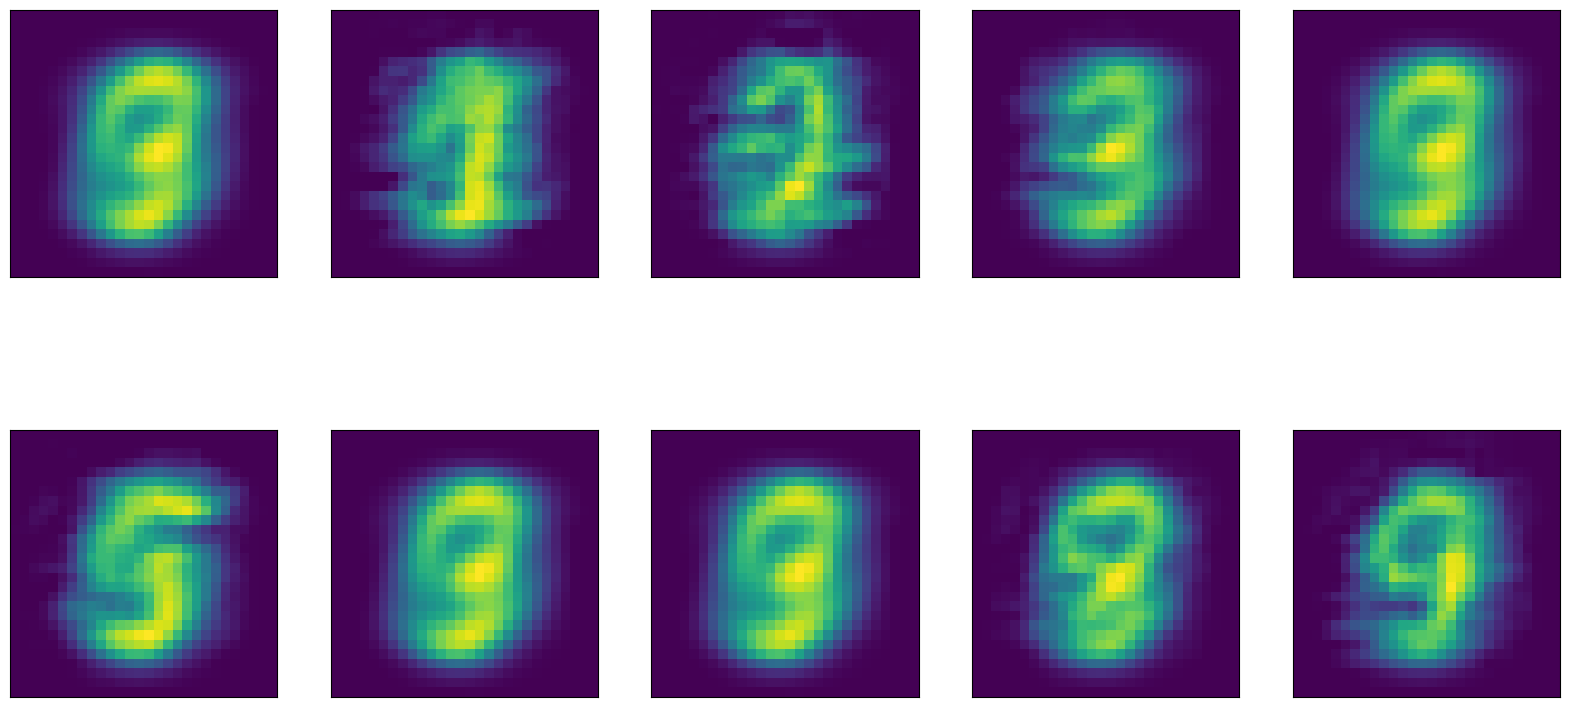

In [18]:
nrows=2
ncols=5
# Creating a figure and axes for our plot
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(20, 10)
    )

# Declaring a counting variable
counter = 0

# Iterating over the axes and plotting the inferred images in them
for i in range(nrows):
    for j in range(ncols):        
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])
        axes[i, j].imshow(X=x_infer_from_average[counter])

        # Incrementing the counter
        counter += 1

# Showing the plotted axes
plt.show()

MIFace managed to recover most of the images, 
though the digits corresponding to images 2 and 3 arent that great